In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 6.3 MB/s 
     |████████████████████████████████| 182 kB 53.7 MB/s 
     |████████████████████████████████| 166 kB 18.7 MB/s 
     |████████████████████████████████| 63 kB 612 kB/s 
     |████████████████████████████████| 166 kB 58.1 MB/s 
     |████████████████████████████████| 162 kB 50.4 MB/s 
     |████████████████████████████████| 162 kB 18.8 MB/s 
     |████████████████████████████████| 158 kB 55.0 MB/s 
     |████████████████████████████████| 157 kB 15.2 MB/s 
     |████████████████████████████████| 157 kB 36.0 MB/s 
     |████████████████████████████████| 157 kB 29.4 MB/s 
     |████████████████████████████████| 157 kB 45.1 MB/s 
     |████████████████████████████████| 157 kB 42.0 MB/s 
     |████████████████████████████████| 157 kB 32.3 MB/s 
     |████████████████████████████████| 157 kB 51.8 MB/s 
     |████████████████████████████████| 156 kB 58.8 MB/s 


In [ ]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 24.4 MB/s 
     |████████████████████████████████| 46 kB 5.0 MB/s 
     |████████████████████████████████| 66 kB 1.2 MB/s 


In [ ]:
# import the necessary packages
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

Implementing IvanNet

In [ ]:
class GMNet:
  # create GMNet model
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation=wandb.config.activation, input_shape=(28,28,1), )) #C1
    model.add(BatchNormalization())
    model.add(AveragePooling2D()) #S2
    model.add(Dropout(wandb.config.dropout))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation=wandb.config.activation)) #C3
    model.add(BatchNormalization())
    model.add(AveragePooling2D()) #S4
    model.add(Dropout(wandb.config.dropout))

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(wandb.config.layers, activation=wandb.config.activation)) #C5
    model.add(Dropout(wandb.config.dropout))
    model.add(Dense(wandb.config.layers, activation=wandb.config.activation)) #F6
    model.add(Dropout(wandb.config.dropout))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

Fetch, Preprocessing and Data Segregation

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "GMNet-sweep"
}

In [ ]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

#Validation
(train_x, val_x, train_y, val_y) = train_test_split(train_x, train_y,test_size=0.25, random_state=42)

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))
logger.info("Validation x: {}".format(val_x.shape))
logger.info("Validation y: {}".format(val_y.shape))

06-11-2022 17:51:32 [INFO] accessing MNIST...


11490434/11490434 [==============================] - 0s 0us/step


06-11-2022 17:51:33 Train x: (45000, 28, 28)
06-11-2022 17:51:33 Train y: (45000,)
06-11-2022 17:51:33 Test x: (10000, 28, 28)
06-11-2022 17:51:33 Test y: (10000,)
06-11-2022 17:51:33 Validation x: (15000, 28, 28)
06-11-2022 17:51:33 Validation y: (15000,)


In [ ]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
  train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
  test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
  val_x = val_x.reshape((val_x.shape[0], 1, 28, 28))

# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
  train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
  test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))
  val_x = val_x.reshape((val_x.shape[0], 28, 28, 1))

In [ ]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))
logger.info("Validation x: {}".format(val_x.shape))
logger.info("Validation y: {}".format(val_y.shape))

06-11-2022 17:51:38 Train x: (45000, 28, 28, 1)
06-11-2022 17:51:38 Train y: (45000,)
06-11-2022 17:51:38 Test x: (10000, 28, 28, 1)
06-11-2022 17:51:38 Test y: (10000,)
06-11-2022 17:51:38 Validation x: (15000, 28, 28, 1)
06-11-2022 17:51:38 Validation y: (15000,)


In [ ]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0
val_x = val_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
val_y = lb.transform(val_y)
test_y = lb.transform(test_y)

Training

In [ ]:
#sweeps
sweep_config = {
    'method': 'random',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
    'activation': {
        'values': ['relu', 'tanh']
        },
    'dropout': {
        'values': [0.20, 0.30, 0.40, 0.50]
    },
    'layers':{
        'values': [120,180,240,300]
    },
    'learning_rate': {
      'values': [0.1, 0.01, 0.001]  
    },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, entity='gildson', project=args["project_name"])

Create sweep with ID: uc4n5obh
Sweep URL: https://wandb.ai/gildson/GMNet-sweep/sweeps/uc4n5obh


In [ ]:
def train():
  global history
  global tracker
  global model
  global run
  run = wandb.init(entity="gildson",project=args["project_name"], job_type="Train")
  # create codecarbon tracker
  # codecarbon is too much verbose, change the log level for more info
  tracker = EmissionsTracker(log_level="critical")
  tracker.start()

  # initialize the optimizer and model
  logger.info("[INFO] compiling model...")
  opt = Adam(learning_rate=run.config.learning_rate)
  model = GMNet.build(width=28, height=28, depth=1, classes=10)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

  # train the network
  logger.info("[INFO] training network...")
  history = model.fit(train_x, train_y,
                validation_data=(val_x, val_y),
                batch_size=32,
                epochs=20, 
                verbose=0,
                callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                    compute_flops=True)])
  
  # get co2 emissions from tracker
  # "CO2 emission (in Kg)"
  emissions = tracker.stop()

  # make predictions
  predictions = model.predict(val_x, batch_size=run.config.batch_size)

  # Evaluation Metrics
  logger.info("Validation Evaluation metrics")
  fbeta = fbeta_score(val_y.argmax(axis=1), 
                      predictions.argmax(axis=1), 
                      beta=1, zero_division=1,average='weighted')
  precision = precision_score(val_y.argmax(axis=1),
                              predictions.argmax(axis=1),
                              zero_division=1,average='weighted')
  recall = recall_score(val_y.argmax(axis=1),
                        predictions.argmax(axis=1),
                        zero_division=1,average='weighted')
  acc = accuracy_score(val_y.argmax(axis=1),
                      predictions.argmax(axis=1))

  logger.info("Validation Accuracy: {}".format(acc))
  logger.info("Validation Precision: {}".format(precision))
  logger.info("Validation Recall: {}".format(recall))
  logger.info("Validation F1: {}".format(fbeta))

  run.summary["Acc"] = acc
  run.summary["Precision"] = precision
  run.summary["Recall"] = recall
  run.summary["F1"] = fbeta
  # number of parameters
  run.summary["Count_Params"] = model.count_params()
  # energy unit is kWh
  run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
  run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
  run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
  run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
  # kg
  run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

In [ ]:
wandb.agent(sweep_id, function=train, count=8)

06-11-2022 17:51:55 Starting sweep agent: entity=None, project=None, count=8
wandb: Agent Starting Run: 46owjavg with config:
wandb: 	activation: tanh
wandb: 	dropout: 0.4
wandb: 	layers: 120
wandb: 	learning_rate: 0.01
06-11-2022 17:51:56 Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gildson. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


06-11-2022 17:52:01 [INFO] compiling model...
06-11-2022 17:52:03 [INFO] training network...
06-11-2022 17:52:04 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


accuracy,▆█████▇▇▆▆▆▆▅▅▅▄▄▅▄▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▃▁▁▁▁▁▂▂▃▃▃▃▄▅▄▅▅▄▅█
val_accuracy,█▇█▇▇▇▅▇▅▇▆▄▅▃▄▄▅▄▁▁
val_loss,▂▂▁▂▂▂▄▃▃▃▄▅▃▆▅▅▄▄▇█
GFLOPs,0.00043
accuracy,0.76367
best_epoch,2
best_val_loss,0.18607
epoch,19
loss,0.74284


Run 46owjavg errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: ERROR Run 46owjavg errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: Agent Starting Run: xewrazm0 with config:
wandb: 	activation: tanh
wandb: 	dropout: 0.2
wandb: 	layers: 300
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


06-11-2022 17:54:39 [INFO] compiling model...
06-11-2022 17:54:39 [INFO] training network...


accuracy,█▂▃▃▂▃▁▃▂▃▃▂▂▁▂▃▂▃▃▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▅▃▄▄▇▅▂▄▆▄▃▁▅▃▆▅▃▆
val_accuracy,▁▃█▄▃▄▅▁▅▄██▄▄▄█▄▁█▃
val_loss,▄▃▂▃▆▄█▃▃▂▃▄▄▂▁▂▆█▄▄
GFLOPs,0.00058
accuracy,0.10111
best_epoch,14
best_val_loss,5.4699
epoch,19
loss,9.01003


Run xewrazm0 errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: ERROR Run xewrazm0 errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: Agent Starting Run: a899dyze with config:
wandb: 	activation: tanh
wandb: 	dropout: 0.5
wandb: 	layers: 180
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


06-11-2022 17:57:16 [INFO] compiling model...
06-11-2022 17:57:16 [INFO] training network...


accuracy,█▂▂▃▅▅▅▆▂▃▄▄▅▃▁▃▆▄▄▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▂▃▃▃▅▃▁▃▃▄▂▃▃▅▂▄▅▃
val_accuracy,▅▄▅█▃█▄▃▄▁▄▃▃▅▅▁▃▄▄█
val_loss,▄▅▄▇▄▃▁▂▄█▆▃▁▅▆▂▃▄▇▄
GFLOPs,0.00047
accuracy,0.1
best_epoch,6
best_val_loss,3.51566
epoch,19
loss,6.3668


Run a899dyze errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: ERROR Run a899dyze errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: Agent Starting Run: vkbrn9q2 with config:
wandb: 	activation: relu
wandb: 	dropout: 0.2
wandb: 	layers: 180
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


06-11-2022 17:59:28 [INFO] compiling model...
06-11-2022 17:59:28 [INFO] training network...


accuracy,▁▆▆▇▇▇▇▇▇▇██████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▄▅█▇▅▇▇█▇▇▇█▇█▇▇
val_loss,█▅▄▄▅▄▁▂▅▂▂▁▁▁▂▁▃▂▂▂
GFLOPs,0.00047
accuracy,0.99122
best_epoch,15
best_val_loss,0.02947
epoch,19
loss,0.02793


Run vkbrn9q2 errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: ERROR Run vkbrn9q2 errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4tmjsj0d with config:
wandb: 	activation: relu
wandb: 	dropout: 0.3
wandb: 	layers: 300
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


06-11-2022 18:02:10 [INFO] compiling model...
06-11-2022 18:02:10 [INFO] training network...


accuracy,▆█▅▄▅▅█▅▅▆▅▃▅▄█▅▆▁▅▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
val_accuracy,▂██▁▃▂▁▂▄▁▁██▂▄▁█▄▂▂
val_loss,▃▃▄▃▁▃▆▄▅▄▂▄▄▄▃▂▃█▇▅
GFLOPs,0.00058
accuracy,0.10356
best_epoch,4
best_val_loss,2.30471
epoch,19
loss,2.31379


Run 4tmjsj0d errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: ERROR Run 4tmjsj0d errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: Agent Starting Run: 5wstiu2a with config:
wandb: 	activation: relu
wandb: 	dropout: 0.2
wandb: 	layers: 120
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


06-11-2022 18:04:43 [INFO] compiling model...
06-11-2022 18:04:43 [INFO] training network...


accuracy,▁▆▆▆▆▇▇▇▇▇▇▇█▇██▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▃▂▂▃▂▂▂▂▂▁▂▂▂▂▂▁▂
val_accuracy,▁▃▄▆▆▆▄▇▇▇▆█▅▇▅█▅▆██
val_loss,▇▄▅▂▇▂▄▂▁▂▁▂█▂▃▂▄▁▄▁
GFLOPs,0.00043
accuracy,0.96987
best_epoch,19
best_val_loss,0.06935
epoch,19
loss,0.14337


Run 5wstiu2a errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
wandb: ERROR Run 5wstiu2a errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'batch_size'")
Detected 5 failed runs in a row at start, killing sweep.
wandb: ERROR Detected 5 failed runs in a row at start, killing sweep.
wandb: To change this value set WANDB_AGENT_MAX_INITIAL_FAILURES=val


Evaluation Metrics

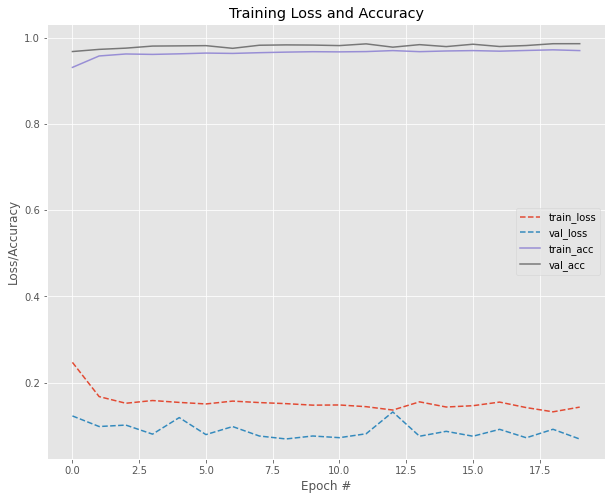

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.003080919765514774 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0001886769740191205 kWh
[INFO] Energy consumed for all GPU: 0.001204888116063608 kWh
[INFO] Energy consumed for all CPU: 0.001687354675432046 kWh
[INFO] CO2 emission 0.0012227406967499123(in Kg)


In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       1.00      0.97      0.98       958
           7       0.97      1.00      0.98      1028
           8       1.00      0.97      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



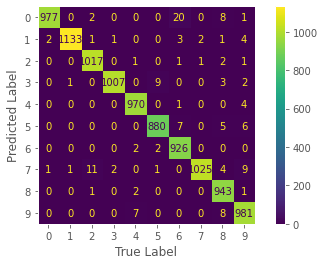

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

06-11-2022 18:09:08 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

06-11-2022 18:09:17 Validation Evaluation metrics
06-11-2022 18:09:17 Validation Accuracy: 0.9859
06-11-2022 18:09:17 Validation Precision: 0.9860500401734689
06-11-2022 18:09:17 Validation Recall: 0.9859
06-11-2022 18:09:17 Validation F1: 0.9858856036421497


In [ ]:
run.finish()